## Differential Evolution for NeuralNetwork Weights Optimization

In [ ]:
## Import Libraries
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
digits = load_digits()
X = digits.data  # 8x8 images flattened to 64 features
y = digits.target  # Digit labels 0-9

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [ ]:
## NeuralNetwork class

class NeuralNetwork(nn.Module):
    def __init__(self, weights=None):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 20)  # Input layer
        self.fc2 = nn.Linear(20, 10)  # Output layer
        
        # Set weights if provided
        if weights is not None:
            self.set_weights(weights)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        F.softmax(x)
        return x
    
    def set_weights(self, weights):
        # Calculate the sizes for each layer
        fc1_weights_size = 64 * 20
        fc1_bias_size = 20
        fc2_weights_size = 20 * 10
        fc2_bias_size = 10
        
        # Extract and reshape weights
        idx = 0
        
        # First layer weights
        self.fc1.weight.data = torch.FloatTensor(
            weights[idx:idx+fc1_weights_size].reshape(20, 64)
        )
        idx += fc1_weights_size
        
        # First layer bias
        self.fc1.bias.data = torch.FloatTensor(
            weights[idx:idx+fc1_bias_size]
        )
        idx += fc1_bias_size
        
        # Second layer weights
        self.fc2.weight.data = torch.FloatTensor(
            weights[idx:idx+fc2_weights_size].reshape(10, 20)
        )
        idx += fc2_weights_size
        
        # Second layer bias
        self.fc2.bias.data = torch.FloatTensor(
            weights[idx:idx+fc2_bias_size]
        )
    
    def get_weights_count(self):
        # Calculate total number of parameters
        return 64*20 + 20 + 20*10 + 10

    def evaluate(self, X, y):
        # Calculate loss and accuracy
        criterion = nn.CrossEntropyLoss()
        outputs = self(X)
        loss = criterion(outputs, y).item()
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y).sum().item() / y.size(0)
        return loss, accuracy, predicted

In [4]:
def plot_predictions(model, X_test, y_test, n_samples=10):
    plt.figure(figsize=(15, 6))
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        
        # Get sample
        img = X_test[idx].reshape(8, 8)
        true_label = y_test[idx]
        
        # Get prediction
        with torch.no_grad():
            pred = model(torch.FloatTensor(X_test[idx]).unsqueeze(0))
            _, pred_label = torch.max(pred, 1)
            pred_label = pred_label.item()
        
        # Plot with color coding (green if correct, red if wrong)
        plt.imshow(img, cmap='gray')
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}, Pred: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    # plt.savefig('mnist_de_predictions.png')
    plt.show()

In [ ]:
class DifferentialEvolution:
    def __init__(self, fitness_func, bounds, NP=50, F=0.5, CR=0.9, generations=1000):
        self.fitness_func = fitness_func
        self.bounds = bounds
        self.NP = NP
        self.F = F
        self.CR = CR
        self.generations = generations
        
        # Constrains of the weights
        self.n = len(bounds)
        self.min_b, self.max_b = np.asarray(bounds).T
        
        self.best_solution = None
        self.best_fitness = None
        
        # History
        self.train_fitness_history = []
        self.train_loss_history = []
        
        
    def initialize_population(self):
        # Random initialization in [0,1], then scale to bounds
        self.pop = np.random.rand(self.NP, self.n)
        self.pop_denorm = self.min_b + self.pop * (self.max_b - self.min_b)
        self.fitness = np.asarray([self.fitness_func(ind) for ind in self.pop_denorm])
        self.best_idx = np.argmax(self.fitness)
        self.best_solution = self.pop_denorm[self.best_idx]
        self.best_fitness = self.fitness[self.best_idx]
        
    def evaluate_best_model(self):

        model = NeuralNetwork(self.best_solution)
        
        # Evaluate on training data
        train_loss, train_acc, _ = model.evaluate(X_train_tensor, y_train_tensor)
        
        # Evaluate on test data
        #test_loss, test_acc = model.evaluate(X_test_tensor, y_test_tensor)
        
        # Store metrics
        self.train_fitness_history.append(train_acc)
        self.train_loss_history.append(train_loss)
        # self.test_fitness_history.append(test_acc)
        # self.test_loss_history.append(test_loss)
        
        return train_acc, train_loss
        
    def evolve(self):
        # Initialize if not already done
        if not hasattr(self, 'pop'):
            self.initialize_population()
            
        # Evaluate initial solution
        self.evaluate_best_model()
        
        for i in range(self.generations):
            for j in range(self.NP):

                # Select three random vectors for mutation
                idxs = [idx for idx in range(self.NP) if idx != j]
                a, b, c = self.pop[np.random.choice(idxs, 3, replace=False)]
                
                # Mutation
                mutant = np.clip(a + self.F * (b - c), 0, 1)
                
                # Crossover
                cross_points = np.random.rand(self.n) < self.CR
                if not np.any(cross_points):
                    cross_points[np.random.randint(0, self.n)] = True
                    
                trial = np.where(cross_points, mutant, self.pop[j])
                trial_denorm = self.min_b + trial * (self.max_b - self.min_b)
                
                # Selection
                f = self.fitness_func(trial_denorm)
                if f > self.fitness[j]:
                    self.fitness[j] = f
                    self.pop[j] = trial
                    if f > self.fitness[self.best_idx]:
                        self.best_idx = j
                        self.best_solution = trial_denorm
                        self.best_fitness = f
            
            # Evaluate and record metrics at the end of each generation
            train_acc, train_loss = self.evaluate_best_model()
            
            print(f"Generation {i+1}/{self.generations}, Loss: {train_loss}, Accuracy: {train_acc:.4f}")
        
        return self.best_solution, self.best_fitness, self.train_fitness_history, self.train_loss_history
    

In [ ]:
def plot_history(acc_de, loss_de, acc_sgd, loss_sgd):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(acc_de, label='Train Accuracy (DE)', color='blue')
    ax1.plot(acc_sgd, label='Train Accuracy (SGD)', color='orange')
    ax1.set_xlabel('Generation/Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Comparison')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(loss_de, label='Train Loss (DE)', color='blue')
    ax2.plot(loss_sgd, label='Train Loss (SGD)', color='orange')
    ax2.set_xlabel('Generation/Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Comparison')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    # plt.savefig('mnist_de_sgd_comparison.png')

In [7]:
def evaluate_fitness(weights):
    model = NeuralNetwork(weights)
    outputs = model(X_train_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
    return accuracy

In [ ]:
model = NeuralNetwork()
n_weights = model.get_weights_count()
print(f"Total weights to optimize: {n_weights}")

# Define bounds for weights (-1 to 1)
bounds = [(-1, 1)] * n_weights
start_de = time.time()
print("Starting differential evolution optimization...")
de = DifferentialEvolution(
  evaluate_fitness, 
  bounds,
  NP=50,
  F=0.5,
  CR=0.9,
  generations=1000
)

solution, fitness, de_acc_history, de_loss_history = de.evolve()
de_time = time.time() - start_de


print(f"Optimization complete. Best fitness (accuracy): {fitness:.4f}")

Total weights to optimize: 1510
Starting differential evolution optimization...
Generation 1/1000, Loss: 10.467495918273926, Accuracy: 0.2283
Generation 2/1000, Loss: 10.467495918273926, Accuracy: 0.2283
Generation 3/1000, Loss: 8.134485244750977, Accuracy: 0.2422
Generation 4/1000, Loss: 8.134485244750977, Accuracy: 0.2422
Generation 5/1000, Loss: 8.134485244750977, Accuracy: 0.2422
Generation 6/1000, Loss: 8.134485244750977, Accuracy: 0.2422
Generation 7/1000, Loss: 8.134485244750977, Accuracy: 0.2422
Generation 8/1000, Loss: 12.841816902160645, Accuracy: 0.2596
Generation 9/1000, Loss: 16.079843521118164, Accuracy: 0.2603
Generation 10/1000, Loss: 16.079843521118164, Accuracy: 0.2603
Generation 11/1000, Loss: 14.436434745788574, Accuracy: 0.2693
Generation 12/1000, Loss: 15.355957984924316, Accuracy: 0.2770
Generation 13/1000, Loss: 13.307658195495605, Accuracy: 0.2839
Generation 14/1000, Loss: 16.651121139526367, Accuracy: 0.2846
Generation 15/1000, Loss: 16.651121139526367, Accura

In [9]:
optimized_model = NeuralNetwork(solution)

_, _, y_pred_ed = optimized_model.evaluate(X_test_tensor, y_test_tensor)
ed_test_acc = (y_pred_ed == y_test_tensor).sum().item() / y_test_tensor.size(0)

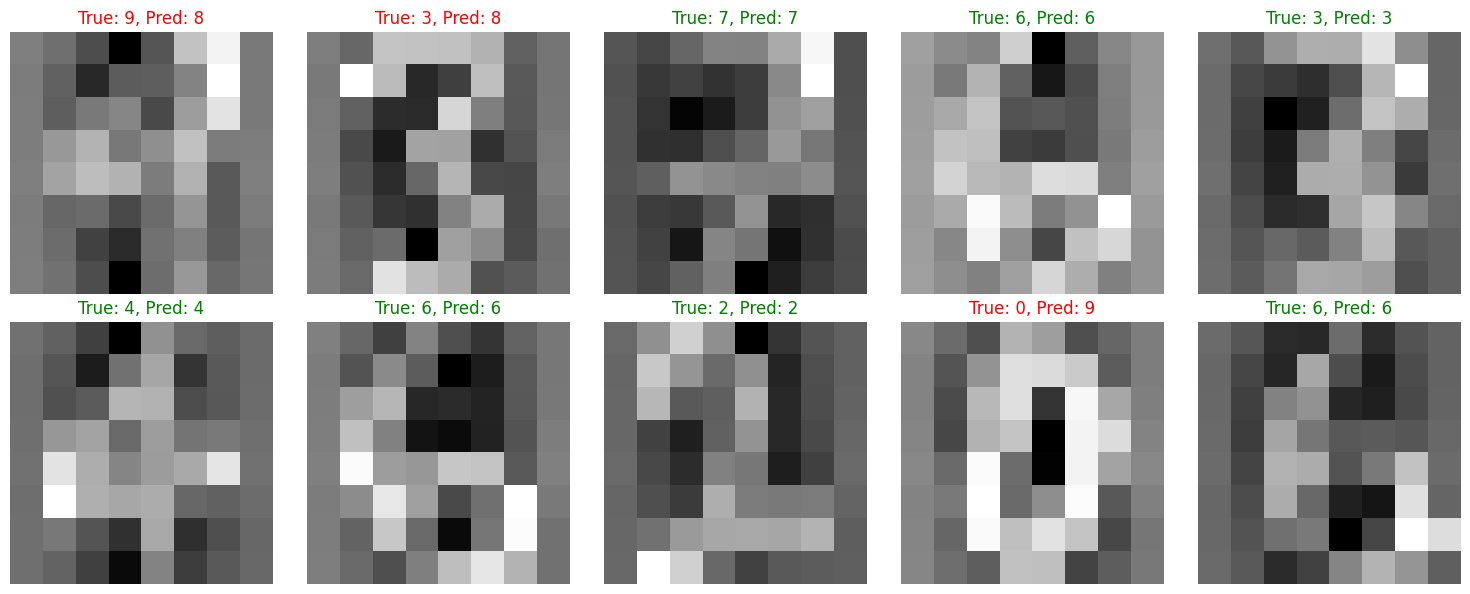

In [10]:
plot_predictions(optimized_model, X_test, y_test)

In [11]:
def train_sgd(model, X_train, y_train, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    train_acc_history = []
    train_loss_history = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Evaluate
        train_loss, train_acc, _ = model.evaluate(X_train, y_train)
        
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"SGD Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Accuracy: {train_acc:.4f}")
    
    return train_acc_history, train_loss_history

Starting SGD optimization...
SGD Epoch 10/1000, Loss: 2.322089433670044, Accuracy: 0.1093
SGD Epoch 20/1000, Loss: 2.2941858768463135, Accuracy: 0.1232
SGD Epoch 30/1000, Loss: 2.2667036056518555, Accuracy: 0.1461
SGD Epoch 40/1000, Loss: 2.2392983436584473, Accuracy: 0.1740
SGD Epoch 50/1000, Loss: 2.212045669555664, Accuracy: 0.2102
SGD Epoch 60/1000, Loss: 2.184903621673584, Accuracy: 0.2429
SGD Epoch 70/1000, Loss: 2.1576790809631348, Accuracy: 0.2693
SGD Epoch 80/1000, Loss: 2.1301417350769043, Accuracy: 0.2944
SGD Epoch 90/1000, Loss: 2.1022450923919678, Accuracy: 0.3194
SGD Epoch 100/1000, Loss: 2.0738513469696045, Accuracy: 0.3459
SGD Epoch 110/1000, Loss: 2.0448944568634033, Accuracy: 0.3786
SGD Epoch 120/1000, Loss: 2.015338659286499, Accuracy: 0.4078
SGD Epoch 130/1000, Loss: 1.9851553440093994, Accuracy: 0.4287
SGD Epoch 140/1000, Loss: 1.9543535709381104, Accuracy: 0.4551
SGD Epoch 150/1000, Loss: 1.9229040145874023, Accuracy: 0.4816
SGD Epoch 160/1000, Loss: 1.89084720611

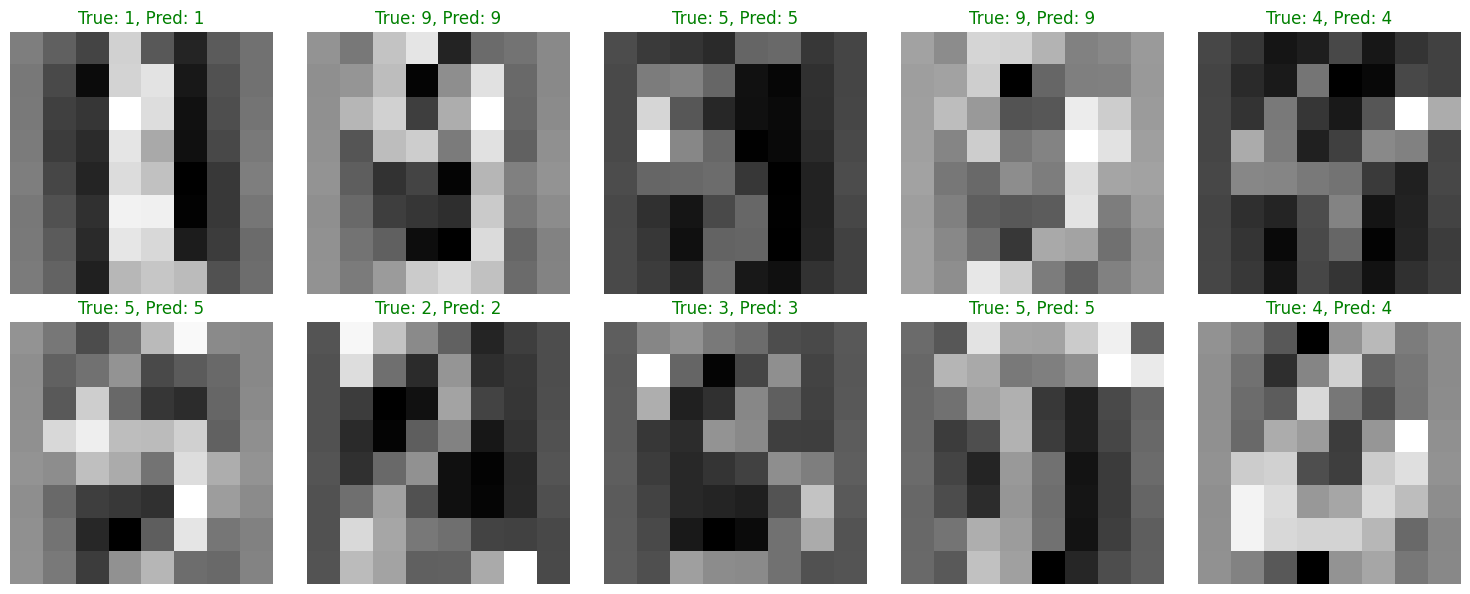

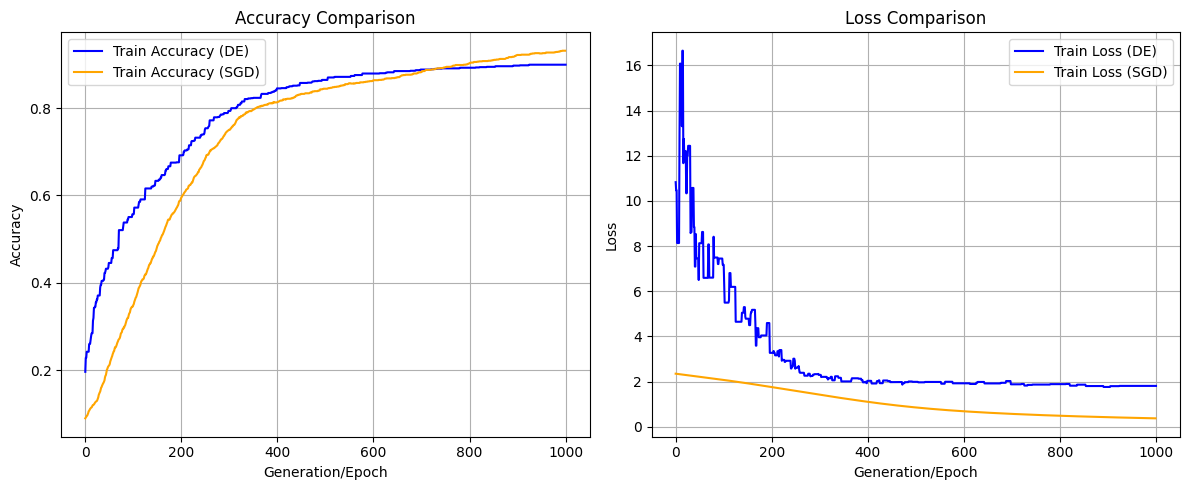

In [ ]:
model = NeuralNetwork() # Reset model

start_sgd = time.time()

# Run SGD optimization
print("Starting SGD optimization...")
sgd_acc_history, sgd_loss_history = train_sgd(
    model, X_train_tensor, y_train_tensor, epochs=1000, lr=0.01
)
sgd_time = time.time() - start_sgd

# Evaluate SGD model on test set
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     _, test_predicted = torch.max(test_outputs.data, 1)
#     sgd_test_accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)


# Visualize SGD predictions
plot_predictions(model, X_test, y_test)

# Plot DE and SGD comparison
plot_history(de_acc_history, de_loss_history, sgd_acc_history, sgd_loss_history)

In [13]:
_, _, y_pred_sgd = model.evaluate(X_test_tensor, y_test_tensor)
sgd_test_acc = (y_pred_sgd == y_test_tensor).sum().item() / y_test_tensor.size(0)

In [14]:
pd.DataFrame([
    {"Accuracy": max(de_acc_history), "Loss": min(de_loss_history)},
    {"Accuracy": max(sgd_acc_history), "Loss": min(sgd_loss_history)},
], index=["DifferentialEvolution", "StochasticGradientDescent"])

,Accuracy,Loss
DifferentialEvolution,0.899095,1.760212
StochasticGradientDescent,0.931106,0.370365


In [20]:
print(f"SGD final test accuracy: {sgd_test_acc:.4f}\n\nDE final test accuracy: {ed_test_acc:.4f}")

SGD final test accuracy: 0.9194

DE final test accuracy: 0.8528


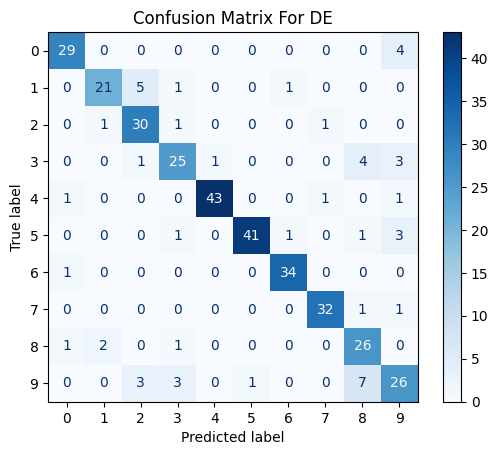

In [16]:
cm = confusion_matrix(y_test, y_pred_ed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix For DE")
plt.show()

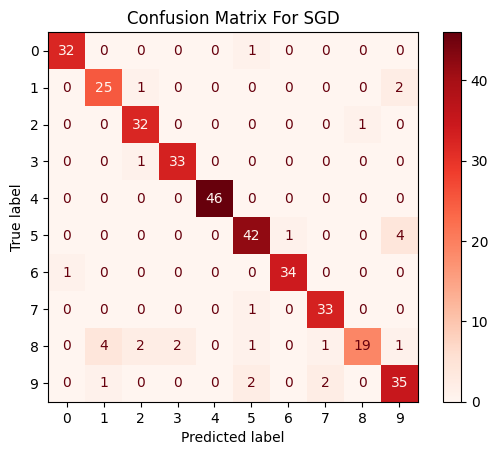

In [17]:
cm = confusion_matrix(y_test, y_pred_sgd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Reds")
plt.title(f"Confusion Matrix For SGD")
plt.show()

In [18]:
report_dict1 = classification_report(y_test, y_pred_ed, output_dict=True)
pd.DataFrame(report_dict1).transpose()

,precision,recall,f1-score,support
0,0.906250,0.878788,0.892308,33.000000
1,0.875000,0.750000,0.807692,28.000000
2,0.769231,0.909091,0.833333,33.000000
3,0.781250,0.735294,0.757576,34.000000
4,0.977273,0.934783,0.955556,46.000000
5,0.976190,0.872340,0.921348,47.000000
6,0.944444,0.971429,0.957746,35.000000
7,0.941176,0.941176,0.941176,34.000000
8,0.666667,0.866667,0.753623,30.000000
9,0.684211,0.650000,0.666667,40.000000


In [19]:
report_dict2 = classification_report(y_test, y_pred_sgd, output_dict=True)
print("Stochastic Gradient Descent")
pd.DataFrame(report_dict2).transpose()

Stochastic Gradient Descent


,precision,recall,f1-score,support
0,0.969697,0.969697,0.969697,33.000000
1,0.833333,0.892857,0.862069,28.000000
2,0.888889,0.969697,0.927536,33.000000
3,0.942857,0.970588,0.956522,34.000000
4,1.000000,1.000000,1.000000,46.000000
5,0.893617,0.893617,0.893617,47.000000
6,0.971429,0.971429,0.971429,35.000000
7,0.916667,0.970588,0.942857,34.000000
8,0.950000,0.633333,0.760000,30.000000
9,0.833333,0.875000,0.853659,40.000000


In [ ]:
print(f"DE time: {de_time}\nSGD Time: {sgd_time}")

DE time: 31.36728000640869
SGD Time: 1.0902481079101562
